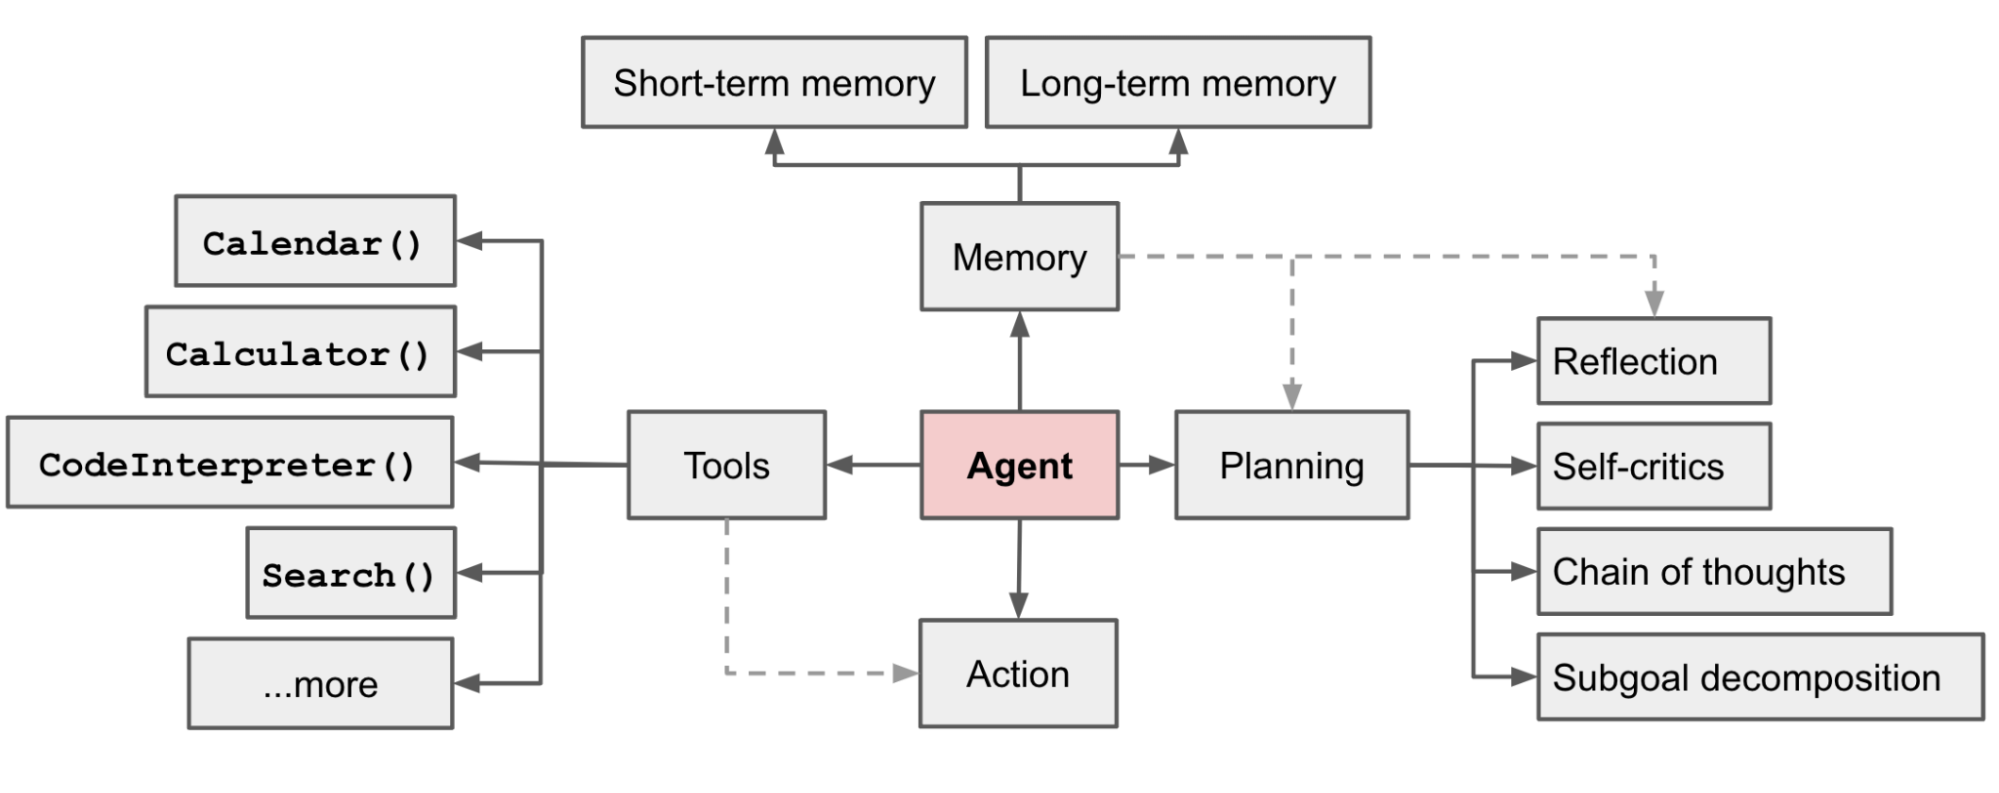

An LLM agent framework can consist of the following core components:

User Request - a user question or request

Agent/Brain - the agent core acting as coordinator

Planning - assists the agent in planning future actions

Memory - manages the agent's past behaviors

In [1]:
# %pip install llama-index-llms-ollama
# %pip install llama-index-embeddings-ollama

# !pip install llama-index
# %pip install docx2txt
# %pip install llama-index-embeddings-huggingface
# %pip install llama-index-embeddings-instructor

from llama_index.core import Settings

# load the ollama
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding


# model set
llama2_7b = "llama2"
llama2_13b = "llama2:13b"
llama3_8b = "llama3:instruct"
llama3_70b = "llama3:70b"

# connect with the ollama server, and talk with llama2 

llm_llama = Ollama(model=llama3_8b, request_timeout=600, temperature=0.1, device='cuda') #base_url = 'http://localhost:11434',
embedding_model = OllamaEmbedding(model_name=llama3_8b,ollama_additional_kwargs={"mirostat": 0}) #base_url="http://localhost:11434"

In [2]:
# resp = llm_llama.stream_complete("how to write a llm agent?")
# for r in resp:
#     print(r.delta, end="")

from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

In [3]:
# %pip install nvidia-ml-py3
import pynvml
# define sample Tool
def get_gpu_stat() -> str:
    """采集系统当前GPU的内存使用情况 """
    print("get_gpu_stat is called\n")

    # 初始化 NVML 库
    pynvml.nvmlInit()

    # 获取 GPU 数量
    num_gpus = pynvml.nvmlDeviceGetCount()
    # print("GPU 数量：", num_gpus)

    # 遍历每个 GPU，获取其资源信息
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        gpu_memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        # print(f"GPU {i}: {gpu_name.decode()}，内存使用情况：{gpu_memory_info.used / 1024 / 1024} MB / {gpu_memory_info.total / 1024 / 1024} MB")
        
    # 关闭 NVML 库
    pynvml.nvmlShutdown()
    str = f""" {gpu_name.decode()}内存使用情况:used-{gpu_memory_info.used / 1024 / 1024} MB / total-{gpu_memory_info.total / 1024 / 1024} MB \n"""
    return str

# gpu_check_tool = FunctionTool.from_defaults(fn=get_gpu_stat,
#                                             name="get the GPU memory usage",
#                                             description="get the system GPU memory usage include the used memory and total memory")

gpu_check_tool = FunctionTool.from_defaults(fn=get_gpu_stat)

In [4]:
# 获取当前系统时间 
import datetime
def get_current_time()->str:
    "获取当前系统时间"
    current_time = datetime.datetime.now()
    # 将时间格式化为字符串
    time_str = current_time.strftime("%Y-%m-%d %H:%M:%S")
    return time_str

# get_time_tool = FunctionTool.from_defaults(fn=get_current_time,
#                                            name="Get the system time",
#                                            description="Get the system time")

get_time_tool = FunctionTool.from_defaults(fn=get_current_time)

In [5]:
# print warning
def print_warning(cur_time:str,percent:float ):
    "打印warning,包含两个输入参数，当前时间和GPU内存利用率"
    print("{}--Warning gpu load high {}!!!\n".format(cur_time,percent))
    return True

# print_warning_tool = FunctionTool.from_defaults(fn=print_warning,
#                                                 name="print warning",
#                                                 description="print the warining, it have two input paramater current_time and percent of gpu load")

print_warning_tool = FunctionTool.from_defaults(fn=print_warning)

In [6]:

# 垃圾回收
import gc

def clean_memory():
    "清理内存"
    print("execute gc collection\n")
    gc.collect()
    return True

clean_memory_tool = FunctionTool.from_defaults(fn=clean_memory)

In [7]:
from llama_index.core import PromptTemplate

# react_system_header_str = """\

# You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.

# ## Tools
# You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.
# This may require breaking the task into subtasks and using different tools to complete each subtask.

# You have access to the following tools:
# {tool_desc}

# ## Output Format
# To answer the question, please use the following format.

# ```
# Thought: I need to use a tool to help me to reach the target.
# Action: tool name (one of {tool_names}) if using a tool.
# Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
# ```

# Please ALWAYS start with a Thought.

# Please use a valid JSON format for the Action Input. Do NOT do this {{'input': 'hello world', 'num_beams': 5}}.

# If this format is used, the user will respond in the following format:

# ```
# Observation: tool response
# ```

# You should keep repeating the above format until you have enough information
# to answer the question without using any more tools. At that point, you MUST respond
# in the one of the following two formats:

# ```
# Thought: I can answer without using any more tools.
# Answer: [your answer here]
# ```

# ```
# Thought: I cannot answer the question with the provided tools.
# Answer: Sorry, I cannot answer your query.
# ```

# ## Additional Rules
# - The answer MUST contain a sequence of bullet points that explain how you arrived at the answer. This can include aspects of the previous conversation history.
# - You MUST obey the function signature of each tool. Do NOT pass in no arguments if the function expects arguments.

# ## Current Conversation
# Below is the current conversation consisting of interleaving human and assistant messages.

# """
# react_system_prompt = PromptTemplate(react_system_header_str)



In [8]:
# initialize ReAct agent
agent = ReActAgent.from_tools([gpu_check_tool, get_time_tool, print_warning_tool,clean_memory_tool], llm=llm_llama, verbose=True)

# # agent.update_prompts({"agent_worker:system_prompt": react_system_prompt})
prompt=agent.get_prompts()
# print(prompt['agent_worker:system_prompt'].metadata)
# print(prompt['agent_worker:system_prompt'].template_vars)
# print(prompt['agent_worker:system_prompt'].output_parser)
# print(prompt['agent_worker:system_prompt'].template_var_mappings)
# print(prompt['agent_worker:system_prompt'].function_mappings)
print(prompt['agent_worker:system_prompt'].template)

You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.

## Tools

You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.
This may require breaking the task into subtasks and using different tools to complete each subtask.

You have access to the following tools:
{tool_desc}


## Output Format

Please answer in the same language as the question and use the following format:

```
Thought: The current language of the user is: (user's language). I need to use a tool to help me answer the question.
Action: tool name (one of {tool_names}) if using a tool.
Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
```

Please ALWAYS start with a Thought.

Please use a valid JSON format for the Action Input. Do NOT do this {{'input': 'hello world', 'num_beams': 

In [9]:
# agent.reset
# print(agent.get_prompts())

agent.chat_history.clear()
print(agent.chat_history)

agent.chat("你的任务是监控系统GPU的内存使用情况,如果GPU使用率大于10%，打印包含当前时间的报警信息,然后清理内存，清理完成后结束")



[]
Thought: I need to monitor the system GPU's memory usage and print a warning message if the usage rate exceeds 10%. Then, I'll clean up the memory after printing the warning.
Action: get_gpu_stat
Action Input: {}
get_gpu_stat is called

Observation:  Tesla V100-PCIE-16GB内存使用情况:used-3646.5625 MB / total-16384.0 MB 

Thought: The current GPU memory usage is 22.2%. Since it exceeds the threshold of 10%, I need to print a warning message and then clean up the memory.
Action: get_current_time
Action Input: {}
Observation: 2024-04-26 08:53:16
Thought: Now that I have the current time, I can use it to print a warning message.
Action: print_warning
Action Input: {'cur_time': '2024-04-26 08:53:16', 'percent': 22.2}
2024-04-26 08:53:16--Warning gpu load high 22.2!!!

Observation: True
Thought: The warning message has been printed, and now it's time to clean up the memory.
Action: clean_memory
Action Input: {}
execute gc collection

Observation: None
Thought: Memory cleaning is complete! Since

AgentChatResponse(response='Task completed successfully!', sources=[ToolOutput(content=' Tesla V100-PCIE-16GB内存使用情况:used-3646.5625 MB / total-16384.0 MB \n', tool_name='get_gpu_stat', raw_input={'args': (), 'kwargs': {}}, raw_output=' Tesla V100-PCIE-16GB内存使用情况:used-3646.5625 MB / total-16384.0 MB \n', is_error=False), ToolOutput(content='2024-04-26 08:53:16', tool_name='get_current_time', raw_input={'args': (), 'kwargs': {}}, raw_output='2024-04-26 08:53:16', is_error=False), ToolOutput(content='True', tool_name='print_warning', raw_input={'args': (), 'kwargs': {'cur_time': '2024-04-26 08:53:16', 'percent': 22.2}}, raw_output=True, is_error=False), ToolOutput(content='None', tool_name='clean_memory', raw_input={'args': (), 'kwargs': {}}, raw_output=None, is_error=False)], source_nodes=[], is_dummy_stream=False)